In [177]:
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
plt.rcParams['figure.figsize'] = [25, 10]
import scipy.linalg as la
import numpy as np
from scipy.interpolate import interp1d, interp2d
import pandas as pd
from scipy.integrate import solve_ivp
from matplotlib.animation import FFMpegWriter
%matplotlib qt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:

m = 0.175 
g = 9.7935 
A = 0.058556
d = 2*np.sqrt(A/np.pi)
rho = 1.225
Ia = 0.002352 
Id = 0.001219 
CMq= -1.44E-02
CRp =-1.25E-02
CNr = -3.41E-05

In [4]:
def update_cond(og_cond, xdot, step):
    cond = og_cond.copy()
    for key in cond.keys():
        cond[key] += (xdot[key]*step)
    return cond

In [5]:
def return_C(C_data):
    CL = []
    radians = []
    for i in range(len(C_data)):
        if i % 2 == 0:
            radians.append(C_data[i])
        else:
            CL.append(C_data[i])
    return pd.DataFrame(data={"radians":radians, "C":CL})

In [15]:
def use_C_constants(alpha, AdvR,interpolate=True):

    if interpolate:
        CL_data = [-0.1745, -0.2250, 
        -0.05236, 0,
        0,       0.150,
        0.08727,0.4500,
        0.17453 ,0.7250,
        0.26180 ,0.9750,
        0.34907 ,1.2000,
        0.43633 ,1.4500,
        0.52360 ,1.6750]

        CD_data=[-0.1745, 0.1500,
        -0.05236, 0.080,
        0, 0.10,
        0.08727, 0.15,
        0.1745, 0.260,
        0.26180, 0.390,
        0.3491, 0.570,
        0.4363, 0.750,
        0.5236, 0.9200]

        CM_data=[-0.174532925, -0.0380 ,
        -0.087266463, -0.0220,
        -0.052359878, -0.0140,
        0, -0.006,
        0.052359878, -0.006,
        0.104719755, -0.002,
        0.157079633, 0.000,
        0.20943951, 0.0100,
        0.261799388, 0.0220,
        0.34906585, 0.0440,
        0.401425728, 0.0600,
        0.453785606, 0.0840,
        0.523598776, 0.11]

        CL_df = return_C(CL_data)
        CD_df = return_C(CD_data)
        CM_df = return_C(CM_data)

        CRr_rad = [-0.0873,-0.0698,-0.0524,-0.0349,-0.0175,0.0000,0.0175,0.0349,0.0524,0.0698,0.0873,0.1047,0.1222,0.1396,0.1571,0.1745,0.1920,0.2094,0.2269,0.2443,0.2618,.5236]
        CRr_AdvR= [2,1.04,0.69,0.35,0.17,0]
        CRr_data = [[-0.0172,-0.0192,-0.018,-0.0192,-0.018,-0.0172,-0.0172,-0.0168,-0.0188,-0.0164,-0.0136,-0.01,-0.0104,-0.0108,-0.0084,-0.008,-0.008,-0.006,-0.0048,-0.0064,-0.008,-0.003],
                [-0.0112,-0.0132,-0.012,-0.0132,-0.012,-0.0112,-0.0112,-0.0108,-0.0128,-0.0104,-0.0096, -0.0068,-0.0072,-0.0076,-0.0052,-0.0048,-0.0048,-0.0028,-0.0032,-0.0048,-0.0064,-0.003],
                [-0.0056,-0.0064,-0.0064,-0.0068,-0.0064,-0.0064,-0.0052,-0.0064,-0.0028,-0.0028,-0.004, -0.002,-0.004,-0.002,-0.0016,0,0,0,0,-0.002,-0.0048,-0.003],
                [-0.0012,-0.0016,-0.0004,-0.0028,-0.0016,-0.0016,-0.0004,0.0004,0.0004,0.0008,0.0004, 0.0008,0.0012,0.0008,0.002,0.0028,0.0032,0.0024,0.0028,0.0004,-0.0012,-0.003],
                [-0.0012,-0.0012,-0.0016,-0.0016,-0.0012,-0.0004,0.0004,0.0008,0.0008,0.0016,0.0004, 0.002,0.0004,0.0016,0.002,0.002,0.002,0.0012,0.0012,0,-0.0012,-0.003],
                [-0.0012,-0.0012,-0.0004,-0.0008,-0.0008,-0.0008,0.0004,0.0004,0.0004,0.0008,0.0004, 0.0008,-0.0004,0,0,0.0004,0,0,0.0004,-0.002,-0.0012,-0.003]]
        CL = interp1d(CL_df['radians'], CL_df['C'], fill_value="extrapolate")(alpha)
        CD = interp1d(CD_df['radians'], CD_df['C'], fill_value="extrapolate")(alpha)
        CM = interp1d(CM_df['radians'], CM_df['C'], fill_value="extrapolate")(alpha)
        CRr = interp2d(CRr_rad,CRr_AdvR, CRr_data)(alpha, AdvR)
    else:
        class Model:
            """
            Coefficient model for a disc. Holds all of the aerodynamic
            parameters coupling the kinematic variables (spins and angles)
            to the force magnitudes.
            """

            PL0: float = 0.33
            PLa: float = 1.9
            PD0: float = 0.18
            PDa: float = 0.69
            PTxwx: float = -0.013
            PTxwz: float = -0.0017
            PTy0: float = -0.082
            PTya: float = 0.43
            PTywy: float = -0.014
            PTzwz: float = -0.000034
            alpha_0: float = 4 * np.pi / 180

            #####################################################################
            # Below are functions connecting physical variables to force/torque #
            # scaling factors (the `C`s)                                        #
            #####################################################################

            self.PL0 + self.PLa * alpha

            self.PD0 + self.PDa * (alpha - self.alpha_0) ** 2

    return CL, CD, CM, CRr

In [34]:
def compute_timestep_v2(t, cond):
    ##########################
    # Establishing variables #
    ##########################
    if type(cond) == dict:
        vx = cond['vx']
        vy = cond['vy']
        vz = cond['vz']
        phi = cond['phi']
        theta = cond['theta']
        sintheta = np.sin(theta)
        costheta = np.cos(theta)
        sinphi = np.sin(phi)
        cosphi = np.cos(phi)
        dphi = cond['dphi']
        dtheta= cond['dtheta']
        dgamma = cond['dgamma']
    else :
        vx = cond[3]
        vy = cond[4]
        vz = cond[5]
        phi = cond[6]
        theta = cond[7]
        sintheta = np.sin(theta)
        costheta = np.cos(theta)
        sinphi = np.sin(phi)
        cosphi = np.cos(phi)
        dphi = cond[8]
        dtheta= cond[9]
        dgamma = cond[10]

    ##################################
    # Creating Transformation Matrix #
    ##################################
    T_c_N= np.array([[costheta, sintheta*sinphi, -sintheta*cosphi,],
            [0, cosphi, sinphi],
            [sintheta, -costheta*sinphi, costheta*cosphi]])

    #THese are the transformation vectors in the x y and z directions
    cx = T_c_N[0]
    cy = T_c_N[1]
    cz = zhat = T_c_N[2]

    # This is the velocity
    velocity = [vx, vy, vz]
    #Taking the magnitude of velocity
    magnitude_v = np.linalg.norm(velocity)

    #Finding the velocity in the Z direction
    velocity_z = np.array(velocity) @ np.array(cz)
    #Projecting the velocity onto the current direction
    projected_velocity = velocity - cz * velocity_z
    
    angle_of_attack = -np.arctan(velocity_z/np.linalg.norm(projected_velocity))

    #Unit velocity
    unit_velocity = velocity / magnitude_v
    # Also known as xhat
    projected_unit_velocity = xhat = projected_velocity/np.linalg.norm(projected_velocity) #xhat
    #This should be the Y direction
    yhat = np.cross(cz, projected_unit_velocity)

    omegaD_N_inC = [dphi*costheta, dtheta, dphi*sintheta+dgamma]; 
    omegaD_N_inN = omegaD_N_inC @ T_c_N

    omegavp = omegaD_N_inN @ projected_unit_velocity #X dir
    omegalat = omegaD_N_inN @ yhat # Y dir
    omegaspin = omegaD_N_inN @ cz # Z dir

    AdvR = d*omegaspin/2/magnitude_v

    CL, CD, CM, CRr = use_C_constants(angle_of_attack, AdvR)

    Adp = A*rho*magnitude_v*magnitude_v/2
    Mvp = Adp*d* (CRr + CRp*omegavp)*projected_unit_velocity
    lift = CL*Adp
    drag = CD*Adp
    ulift = np.cross(unit_velocity,yhat) 
    udrag = -unit_velocity
    Fup = lift*ulift + drag*udrag
    Fdown = [0, 0, m*g]
    Ftotal= Fup - Fdown

    angular_velocity = [cond['dphi'], cond['dtheta'], cond['dgamma']]
    w_prime = np.array(
                [
                    angular_velocity[0] * costheta,
                    angular_velocity[1],
                    angular_velocity[0] * sintheta + angular_velocity[2],
                ]
            )
    w_lab = w_prime @ T_c_N
    w = np.array([xhat, yhat, zhat]) @ w_lab

    t_amplitude = Adp * d

    PTxwx = -0.013
    PTxwz = -0.0017
    PTy0 = -0.082
    PTya = 0.43
    PTywy = -0.014
    PTzwz = -0.000034
    tq_x = (PTxwx * w[0] + PTxwz * w[2]) * t_amplitude * xhat
    tq_y = (PTy0 + PTywy * w[1] + PTya * angle_of_attack) * t_amplitude * yhat
    tq_z = PTzwz * w[2] * t_amplitude * zhat


    T = tq_x + tq_y + tq_z


    xdot = dict({
    "x" : velocity[0],
    "y" : velocity[1], 
    "z" : velocity[2],
    "vx" : Ftotal[0] / m,
    "vy" : Ftotal[1] / m,
    "vz" : Ftotal[2] / m,
    "phi": dphi,
    "theta": dtheta,
    "dphi": T[0],
    "dtheta": T[1],
    })

    xdot["dgamma"] =T[2]
    xdot['gamma'] = cond['dgamma']
    return xdot

In [180]:
cond = dict(
        {
            "x": 0,
            "y": 0,
            "z": 5.0,
            "vx": 10.0,
            "vy": 3,
            "vz": 10,
            "phi": 0,
            "theta": 0,
            "gamma": 0,
            "dphi": 0,
            "dtheta": 0,
            "dgamma": -1400.0,
        })
t = 1
tfinal = 100
total_secs = 5
tstep = total_secs / tfinal
x = []
y = []
z = []
image = plt.imread('flying-disc.png')
image_box = OffsetImage(image, zoom=0.1)
print(f"The Timestep for this simulation is {tstep} seconds")

ax = plt.axes(projection='3d')
ax.set_title('Frisbee Flight Path', fontsize=15)
ax.set_xlabel('X')
ax.set_ylabel('Y')

ax.set_xlim3d(0,20)
ax.set_ylim3d(-10,10)
ax.set_zlim3d(0,5)
fig = plt.figure()
metadata = dict(title='Movie Test', artist='Matplotlib',
                comment='Movie support!')
writer = FFMpegWriter(fps=15, metadata=metadata)
writer.setup(fig, "writer_test.mp4", dpi=200)
with writer.saving(fig, "writer_test.mp4", dpi=200):
    while cond['z'] >= 0:
        xdot = compute_timestep_v2(0, cond)
        updated = update_cond(cond, xdot, tstep)
        cond = updated
        t += 1
        x.append(cond['x'])
        y.append(cond['y'])
        z.append(cond['z'])

        plt.clf()
        
        ax = plt.axes(projection='3d')
        ax.set_title('Frisbee Flight Path', fontsize=15)
        ax.set_xlabel('X')
        ax.set_ylabel('Y')

        ax.set_xlim3d(0,20)
        ax.set_ylim3d(-10,10)
        ax.set_zlim3d(0,5)
    
        ax.plot(x,y,z, marker=planet_marker, markerfacecolor="white",markeredgecolor="blue",c="g", markersize=25)
        plt.draw()
        plt.pause(0.01)
        writer.grab_frame()
    
print(f"The Total Time the Disc Spent in the Air was {tstep * t} seconds")

The Timestep for this simulation is 0.05 seconds
The Total Time the Disc Spent in the Air was 2.5 seconds


In [145]:
from svgpathtools import svg2paths
from svgpath2mpl import parse_path
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

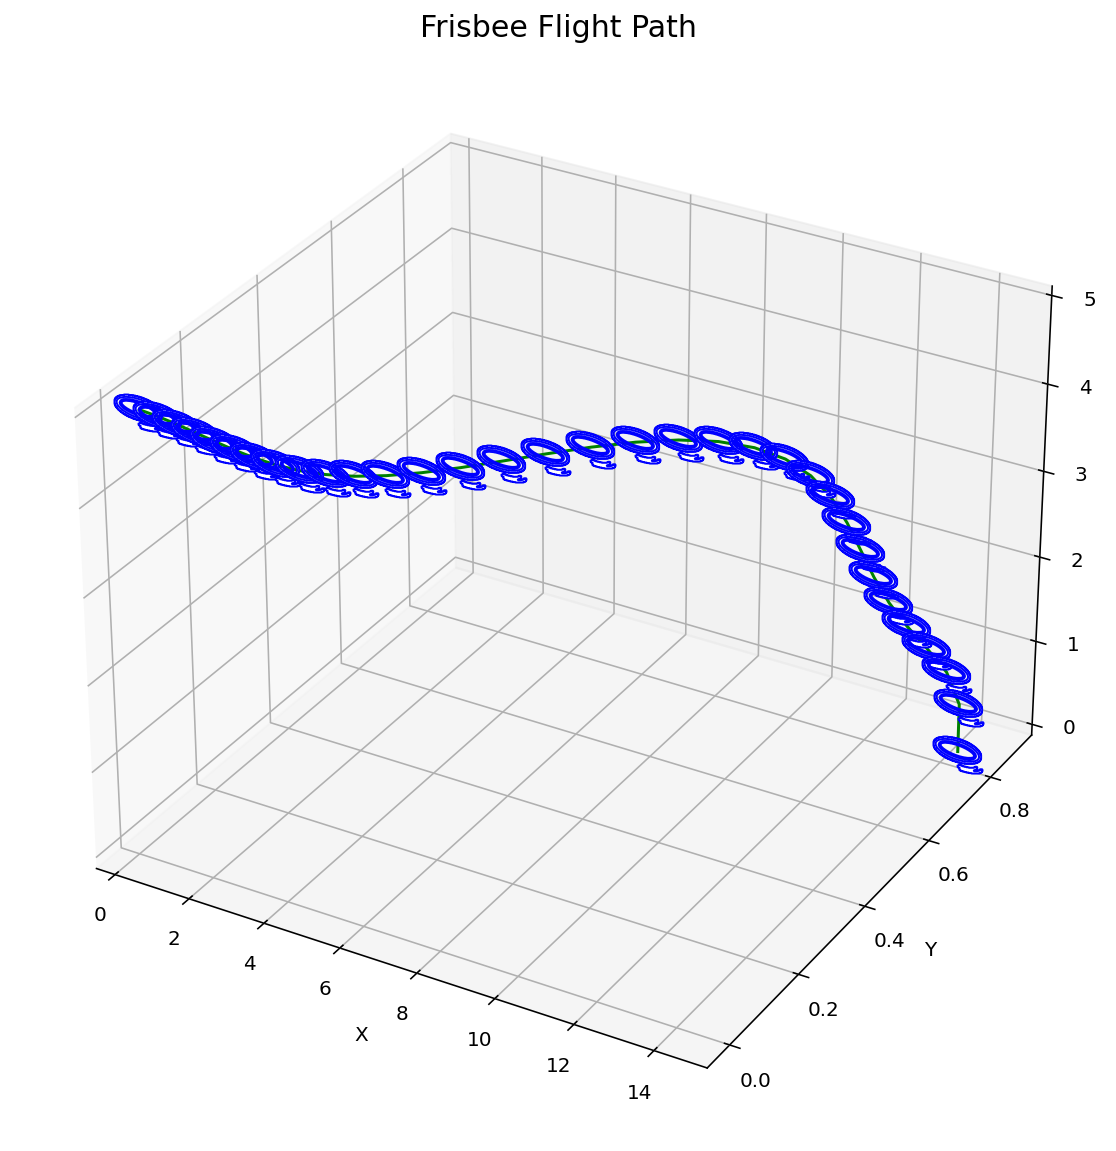